# U.K. Reported Car Accidents

Binary classification models will be used to predict fatal vs. non-fatal car accidents using information most often given in vehicle insurance applications. One limitation is the lack of some valuable features, including driving records. Successful models could be used by vehicle insurance companies when pricing premiums.


Dataset presents sampling bias, as it's unknown the details of unreported car accidents, but I would speculate that fatal car accidents rarely go unreported so it may not be especially problematic for the intended purposes. 


note: Initially, the goal metric was accuracy, but depending on the intentions of the models, recall may be more appropriate, so it has been explored as well.



*_dataset provided by:_
https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data


## importing

In [1]:
# import
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn import svm, tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, r2_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
scaler = MinMaxScaler()
%matplotlib inline
import itertools
import pprint

Using TensorFlow backend.


In [2]:
# model diagnostics and confusion matrix
def model_report(model): 
    
    """ for displaying model metrics
    
    prints train, test, and cross validation score
    classification report, confusion matrix and AUC curve also shown below
    """
    
    print('\nCross Validation Scoring:\n')
    
    train_score = model.score(X_train, y_train)
    print("train score: {:.4}%".format(train_score * 100))
    test_score = model.score(X_test, y_test)
    print("test score: {:.4}%".format(test_score * 100))
    cv_score = np.mean(cross_val_score(model, X, y, cv=3))
    print("cross val score: {:.4}%".format(cv_score * 100))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(actuals, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("AUC  : {:.4}%\n".format(roc_auc * 100))
    
    print("\nClassification Report:")
    print(classification_report(actuals, predictions))
    print('\nConfusion matrix:'.format(accuracy_score))
    display(pd.DataFrame(confusion_matrix(y_test, predictions),
                 columns=['pred non', 'pred fatal'], index=['actual non', 'actual fatal']))
    
    # AUC plot
    plt.figure(figsize=(5, 4))
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [3]:
# plotting feature importances
def plot_feats(model):
    """bar plot for feature importance"""
    
    n_features = X.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), (X.columns.values)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

## eda

### data basics

In [4]:
# Accident data
df = pd.read_csv('Accidents_categorical.csv')

In [5]:
pandas_profiling.ProfileReport(df)

Number of variables,33
Number of observations,251832
Total Missing (%),0.0%
Total size in memory,63.4 MiB
Average record size in memory,264.0 B
Numeric,14
Categorical,19
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [6]:
df.shape

(251832, 33)

In [7]:
# assign target classes binary
df["Accident_Severity"]= df['Accident_Severity'].replace("Fatal_Serious", 1)
df["Accident_Severity"]= df['Accident_Severity'].replace("Slight", 0)

In [8]:
# # percent fatal/non

fatal = df[df['Accident_Severity'] == 1]
nonFatal = df[df['Accident_Severity'] == 0]

print('fatal :',round(len(fatal)/len(df)*100),'%')
print('non Fatal :',round(len(nonFatal)/len(df)*100),'%')

fatal : 25 %
non Fatal : 75 %


Although it's not outlandishly large, I'll be using a fraction of data for now, but will come back to later for better practice. I still want to leave room to undersample the majority class for more balanced learning if I decide to go that route as well.

** use full dataset in future work **

In [9]:
# random % sample of data
df = df.sample(frac=.2, random_state=3)

### eliminating unneeded features

Some features will be excluded, as they wouldn't be available in your typical car insurance application. Only those involving the driver, car, and location will be of use.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50366 entries, 15366 to 228451
Data columns (total 33 columns):
Accident_Index             50366 non-null object
Latitude                   50366 non-null float64
Longitude                  50366 non-null float64
Region                     50366 non-null object
Urban_or_Rural_Area        50366 non-null object
X1st_Road_Class            50366 non-null object
Driver_IMD_Decile          50366 non-null int64
Speed_limit                50366 non-null int64
Road_Type                  50366 non-null object
Road_Surface_Conditions    50366 non-null object
Weather                    50366 non-null object
High_Wind                  50366 non-null object
Lights                     50366 non-null object
Datetime                   50366 non-null object
Year                       50366 non-null int64
Season                     50366 non-null int64
Month_of_Year              50366 non-null int64
Day_of_Month               50366 non-null int64
Day_of_W

In [11]:
#dropping columns relating to time and weather or road conditions.
df.drop(columns= 
    [
        'Accident_Index','Datetime', 'Year'
        ,'Latitude', 'Longitude'
        ,'X1st_Road_Class'
      ,'Speed_limit'
        , 'Road_Type', 'Road_Surface_Conditions', 'Weather'
       ,'High_Wind', 'Lights', 'Season', 'Month_of_Year'
       ,'Day_of_Month','Day_of_Week','Hour_of_Day', 'Number_of_Vehicles'
        ,'Junction_Detail','Junction_Location','X1st_Point_of_Impact','Vehicle_Manoeuvre'
        ]
, axis=1, inplace=True)

### categorical features

In [12]:
col_list = list(df.select_dtypes(include=['object']).columns)
for col in col_list:
    print('--',col,'--')
    print(df[col].value_counts(),'\n')

-- Region --
South East England          9589
London                      6823
North West England          6273
Yorkshire and the Humber    5441
East England                5406
South West England          5166
Wast Midlands               5130
East Midlands               4179
North East England          2208
Wales                         86
Scotland                      65
Name: Region, dtype: int64 

-- Urban_or_Rural_Area --
Urban    31355
Rural    19011
Name: Urban_or_Rural_Area, dtype: int64 

-- Driver_Journey_Purpose --
Other/Not known                37254
Journey as part of work         6785
Commuting to/from work          5553
Taking pupil to/from school      670
Pupil riding to/from school      104
Name: Driver_Journey_Purpose, dtype: int64 

-- Propulsion_Code --
Petrol       32516
Heavy oil    17850
Name: Propulsion_Code, dtype: int64 

-- Vehicle_Make --
Ford          6405
Vauxhall      6224
Other         4841
Peugeot       3679
Volkswagen    3501
Honda         2845
Renault

I'm seeing a few columns with low counts of minority groups. There's a few I was considering merging, or excluding, but I think I'll see how the models perform without those alterations.


Also some concern with the amount of 'other' in driver journey purpose, as that could make things a bit noisy. The specified purposes could also be included in the other/unknown category. I don't think eliminating the column altogether or eliminating the 'other' rows would be a good choice here either, though, so I will leave that part alone.

### numeric

looking at distributions and correlations

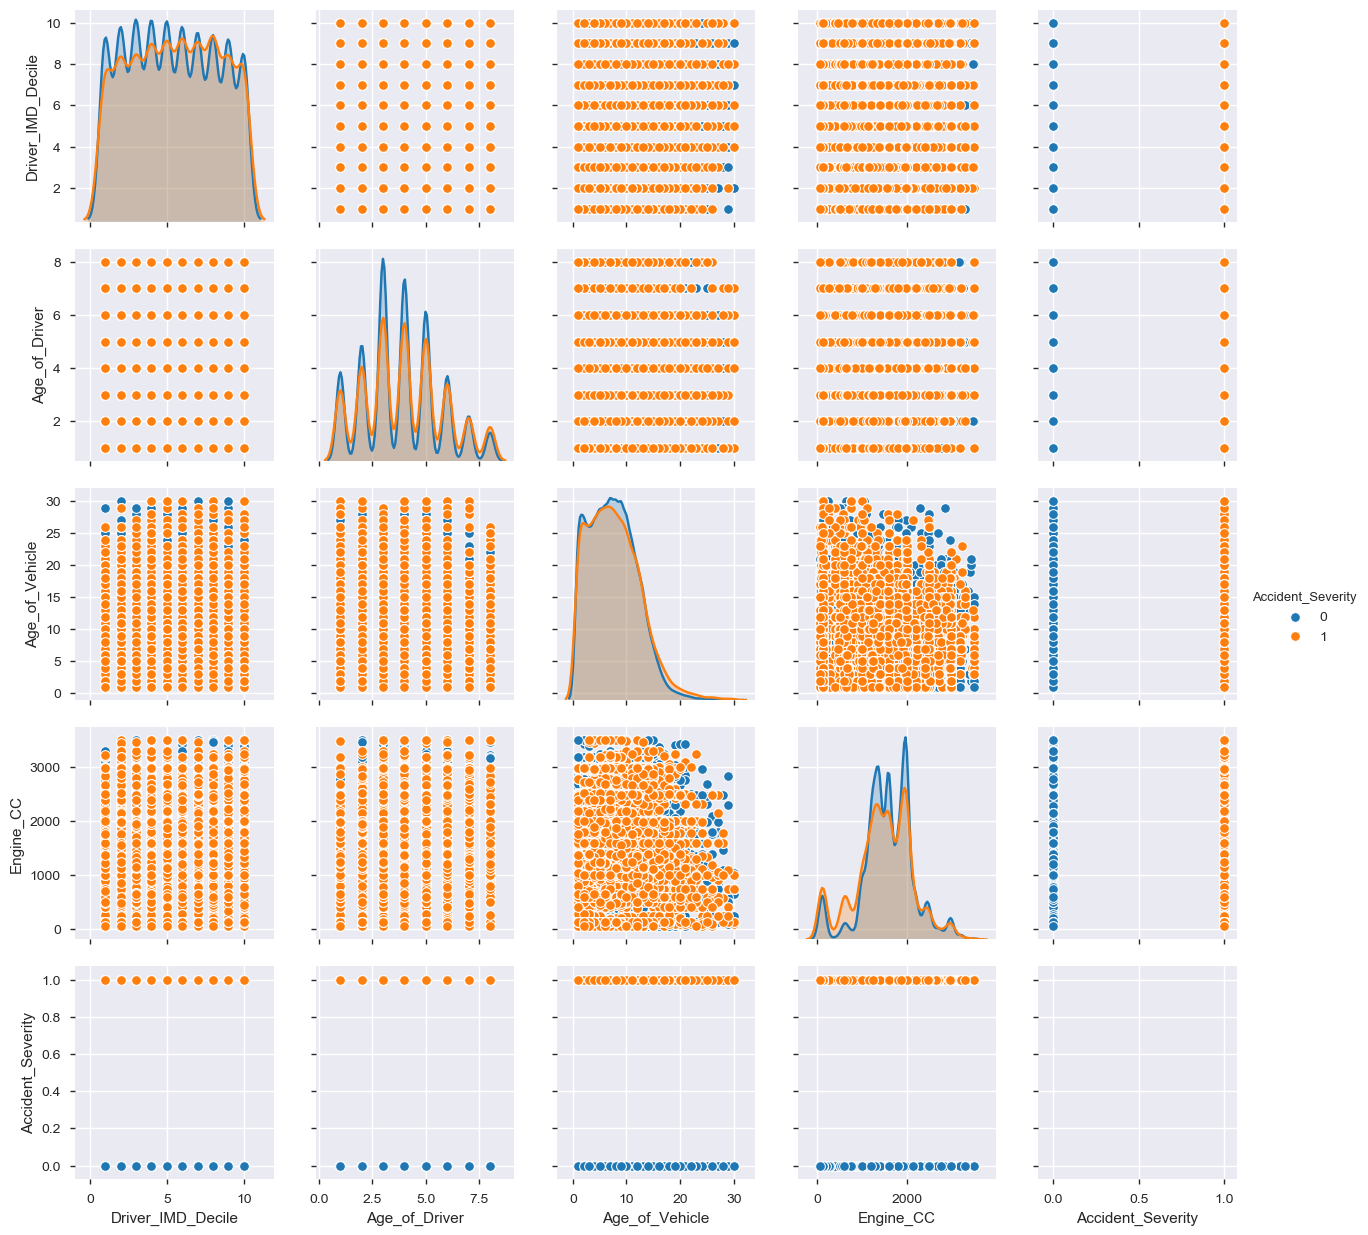

In [13]:
# distributions and interactions by accident severity
sns.pairplot(df, hue = 'Accident_Severity')

### closer look at interactions /patterns

Checking correlations between variables to make sure features aren't overly correlated with each other, such as the 'region' and 'urban_or_rural_area' relationship, and the 'vehicle make' and 'vehicle category' relationship.

In [14]:
#resampling for easier scaled visualizations
df1= df.copy()
df1 = resample(nonFatal, replace=True, n_samples=len(fatal))
df1 = pd.concat([fatal, df1])

__Region vs Urban/Rural__

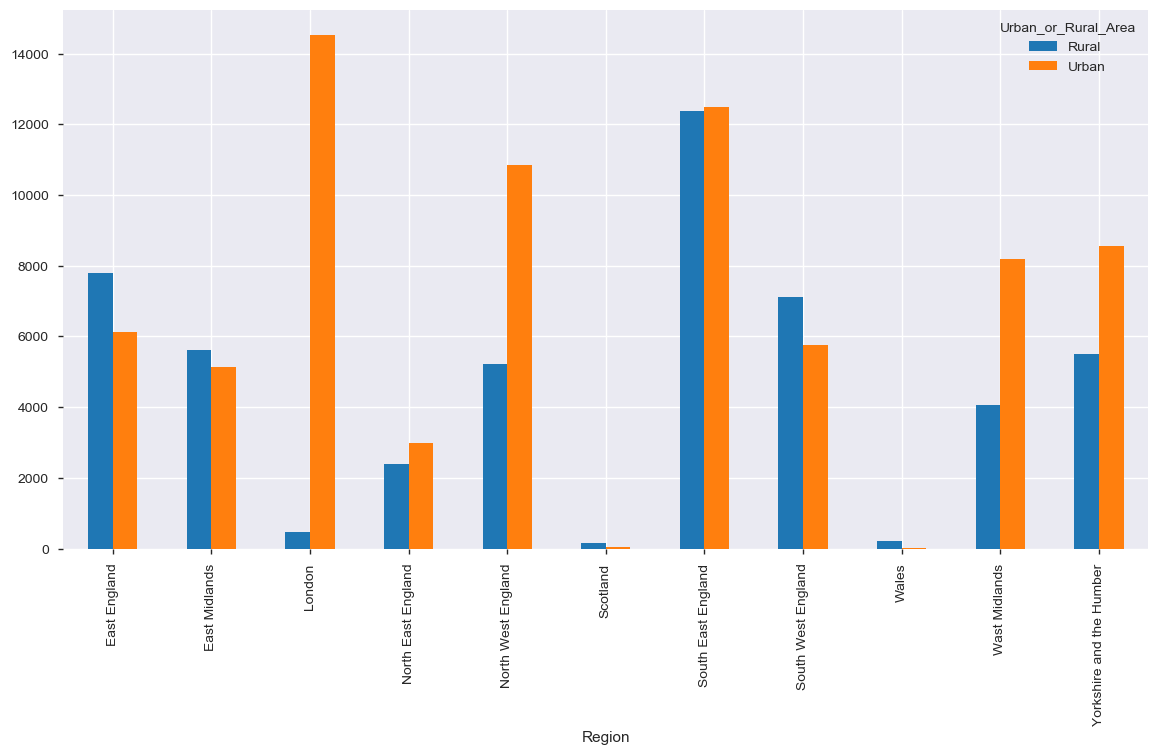

In [15]:
#correlation: region and urban or rural area
df1.groupby(['Region'])['Urban_or_Rural_Area'].value_counts().unstack().plot.bar(figsize=(14,7));

London and North West England do weigh heavily on the Urban side. Scotland and Wales hardly show any data, would consider eliminating or grouping in future.

___

__Vehicle make vs vehicle category__


Another concern is the potential high correlation between vehicle category and vehicle make. Some makes could exclusively produce one category of vehicle, in which case, using one feature or the other might be more practical.

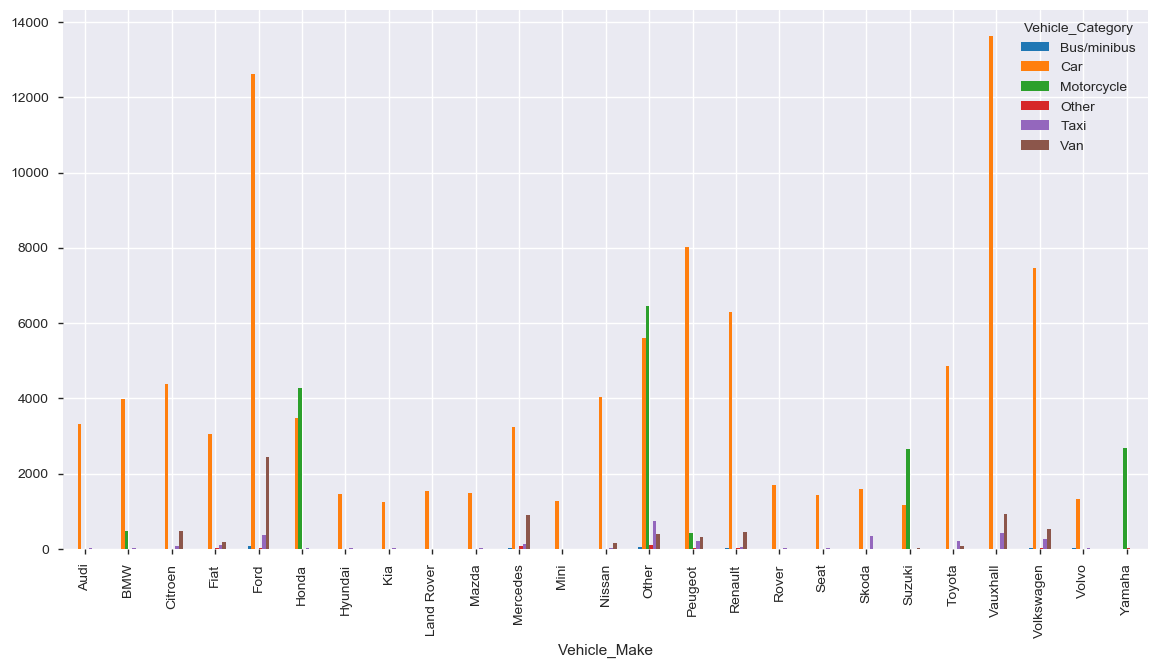

In [16]:
#correlations: vehicle make and vehicle category
df1.groupby(['Vehicle_Make'])['Vehicle_Category'].value_counts().unstack().plot.bar(figsize=(14,7));

The vehicle type is dominantly 'car', and the category is very imbalanced with most makes, otherwise there's considerable variance

___

__age of vehicle vs age of driver__

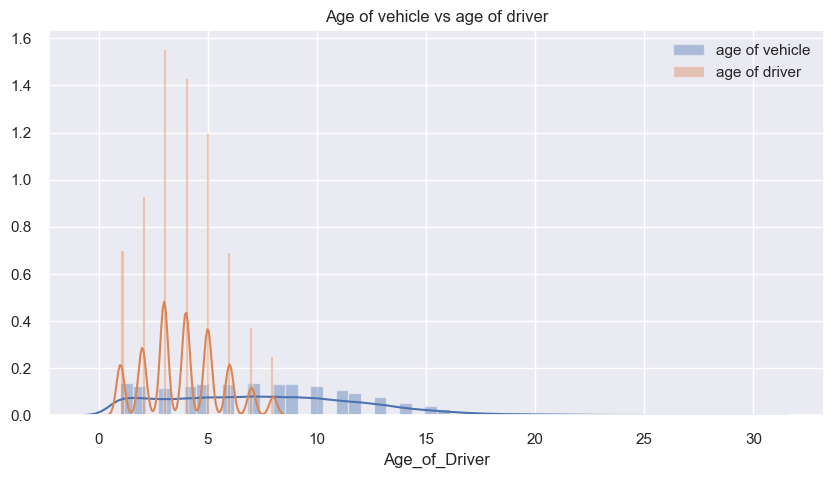

In [17]:
# engine cc and fatal/nonFatal
sns.set(rc={'figure.figsize':(10, 5)})
plt.title("Age of vehicle vs age of driver")
sns.distplot(df['Age_of_Vehicle'], label='age of vehicle') 
sns.distplot(df['Age_of_Driver'], label='age of driver')
plt.legend()
plt.show();

__accident severity and vehicle makes__

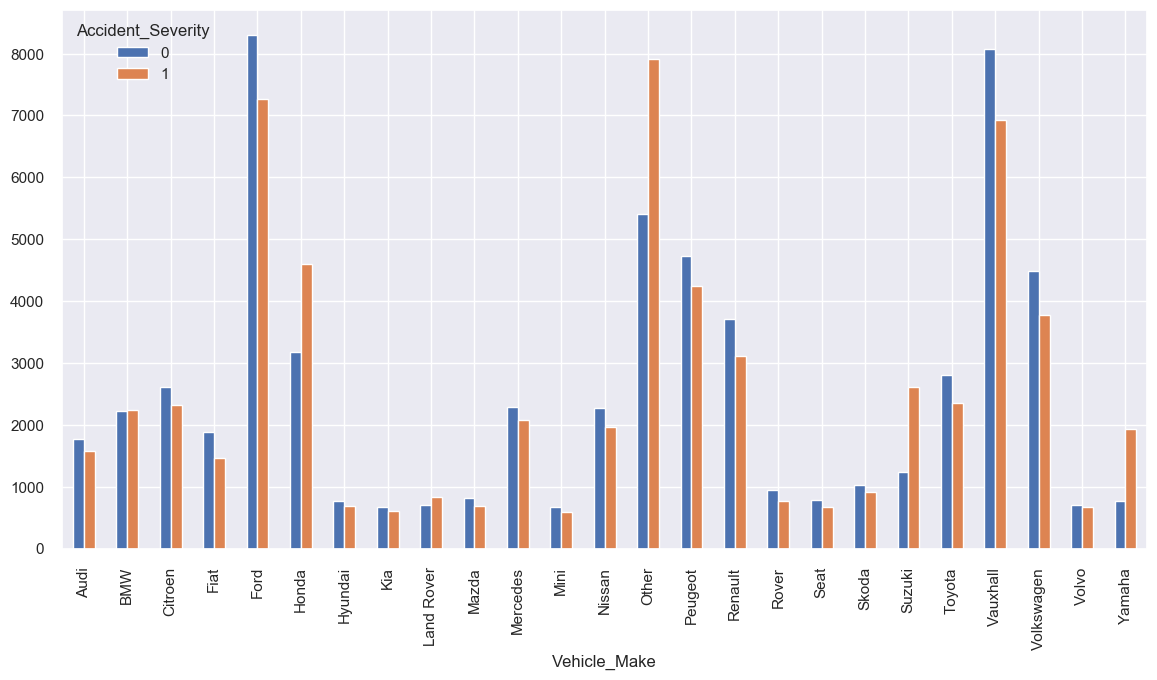

In [18]:
#vehicle makes and accident severity
df1.groupby(['Vehicle_Make'])['Accident_Severity'].value_counts().unstack().plot.bar(figsize=(14,7));

Yamaha and Suzuki show twice as many fatal accidents than non fatal, probably having something to do with them being motorcycle dominant.

___
__Engine cc and accident severity__

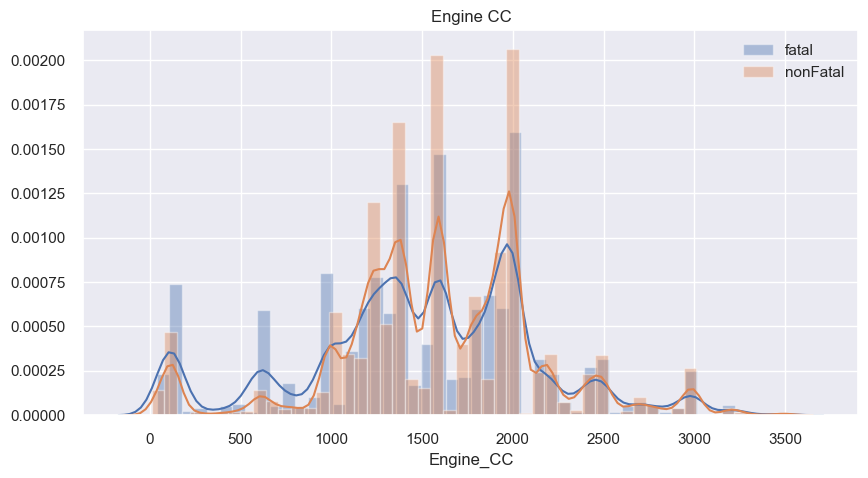

In [19]:
# engine cc and fatal/nonFatal
sns.set(rc={'figure.figsize':(10, 5)})
plt.title("Engine CC")
sns.distplot(fatal['Engine_CC'], label='fatal') 
sns.distplot(nonFatal['Engine_CC'], label='nonFatal')
plt.legend()
plt.show();

___

__age of vehicle and accident severity__

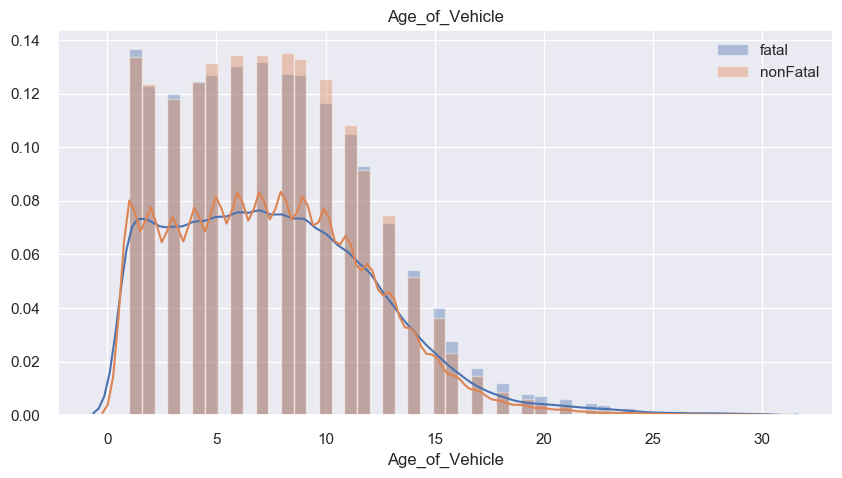

In [20]:
# age of vehicle
sns.set(rc={'figure.figsize':(10, 5)})
plt.title("Age_of_Vehicle")
sns.distplot(fatal['Age_of_Vehicle'], label='fatal') 
sns.distplot(nonFatal['Age_of_Vehicle'], label='nonFatal')
plt.legend()
plt.show();

___

### train test split & other prep

In [21]:
# assign target accident severity
y = df["Accident_Severity"]

#remove target from features
df.drop(columns= ['Accident_Severity'], axis=1, inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50366 entries, 15366 to 228451
Data columns (total 10 columns):
Region                    50366 non-null object
Urban_or_Rural_Area       50366 non-null object
Driver_IMD_Decile         50366 non-null int64
Age_of_Driver             50366 non-null int64
Age_of_Vehicle            50366 non-null int64
Driver_Journey_Purpose    50366 non-null object
Engine_CC                 50366 non-null int64
Propulsion_Code           50366 non-null object
Vehicle_Make              50366 non-null object
Vehicle_Category          50366 non-null object
dtypes: int64(4), object(6)
memory usage: 5.5+ MB


In [23]:
# dummy categorical features
col_list = list(df.select_dtypes(include=['object']).columns)

# create dummies for categorical features, assign to X
df = pd.DataFrame(pd.get_dummies(data=df,columns=col_list
                           , drop_first=True
                   , prefix=col_list))
X = df

In [24]:
#train-test split 80%/20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=3)
actuals=y_test

__Scaling and setting pca__

Initially, I had also used resampling methods to balance the classes, but interestingly the models had a tendency to perform worse across all metrics.

In [25]:
# scale train and test features seperately
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [26]:
#how many rows and features after the data prep
X.shape

(50366, 49)

In [27]:
# looking to keep enough to maintain 90% explained variance
pca = PCA(n_components=.95)
principalComponents = pca.fit_transform(X_train)
print(np.sum(pca.explained_variance_ratio_))

0.9386865940093645


## decision tree

In [28]:
# initialize and fit default decision tree
dt_model = Pipeline(steps=[('pca', pca),('dt_model', DecisionTreeClassifier(random_state=3))])
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)


Cross Validation Scoring:

train score: 99.68%
test score: 63.77%
cross val score: 63.68%
AUC  : 53.32%


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      7562
           1       0.29      0.32      0.31      2512

    accuracy                           0.64     10074
   macro avg       0.53      0.53      0.53     10074
weighted avg       0.65      0.64      0.64     10074


Confusion matrix:


,pred non,pred fatal
actual non,5608,1954
actual fatal,1696,816


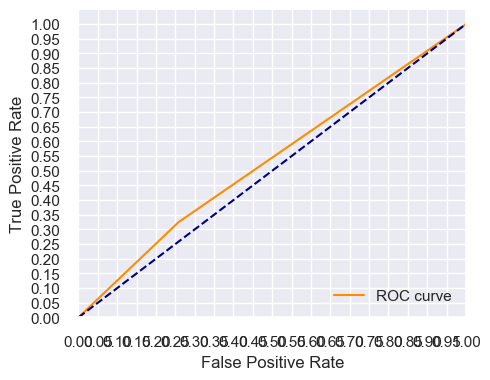

In [29]:
model_report(dt_model)

### random grid

In [30]:
print(dt_model)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=40,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('dt_model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=3,
                                        splitter='best'))],
         verbose=False)


In [31]:
# set random search params
criterion=['gini','entropy']
max_leaf_nodes = [None,10,75,90,100,150,500]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 100, num = 1)]
max_depth.append(None)
min_samples_split = [.1,2,3,4,5,6]
min_samples_leaf = [3,50,10,100,200,300]
bootstrap = [True, False]

random_grid = {'dt_model__criterion':criterion,
               'dt_model__max_leaf_nodes': max_leaf_nodes,
               'dt_model__max_features': max_features,
               'dt_model__max_depth': max_depth,
               'dt_model__min_samples_split': min_samples_split,
               'dt_model__min_samples_leaf': min_samples_leaf
               }

# random grid search
dt_random = RandomizedSearchCV(estimator = dt_model
                               , param_distributions = random_grid
                               , n_iter = 100, cv = 5, verbose=1, error_score=0
                               , scoring=('accuracy')
                               , random_state=3, n_jobs = -1);
# fit random search model
dt_random.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


RandomizedSearchCV(cv=5, error_score=0,
                   estimator=Pipeline(memory=None,
                                      steps=[('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=40,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('dt_model',
                                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                        

In [32]:
dt_random.best_params_

{'dt_model__min_samples_split': 6,
 'dt_model__min_samples_leaf': 300,
 'dt_model__max_leaf_nodes': None,
 'dt_model__max_features': 'sqrt',
 'dt_model__max_depth': None,
 'dt_model__criterion': 'entropy'}

### grid search

In [33]:
# grid search params
param_grid_dt = [
    {'dt_model__criterion': ['entropy','gini'],
    'dt_model__max_depth': [None],
    'dt_model__min_samples_split': [4,5,6,7],
    'dt_model__min_samples_leaf': [280,300,320],
     'dt_model__max_features':['sqrt'],
     'dt_model__max_leaf_nodes':[None]
     
    }
]

# grid search
gs_dt = GridSearchCV(estimator=dt_model,
                    param_grid=param_grid_dt,
                     error_score=0,
                    scoring=('accuracy'),
                    cv=5, n_jobs=-1, verbose=2)

# fitting grid search
gs_dt.fit(X_train, y_train);

# best parameters
print('Best score: {:.3}%'.format(gs_dt.best_score_ * 100))
print('params:\n', gs_dt.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   37.2s finished


Best score: 75.5%
params:
 {'dt_model__criterion': 'entropy', 'dt_model__max_depth': None, 'dt_model__max_features': 'sqrt', 'dt_model__max_leaf_nodes': None, 'dt_model__min_samples_leaf': 300, 'dt_model__min_samples_split': 5}



Cross Validation Scoring:

train score: 75.67%
test score: 75.51%
cross val score: 75.25%
AUC  : 52.52%


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.98      0.86      7562
           1       0.58      0.07      0.12      2512

    accuracy                           0.76     10074
   macro avg       0.67      0.53      0.49     10074
weighted avg       0.71      0.76      0.67     10074


Confusion matrix:


,pred non,pred fatal
actual non,7440,122
actual fatal,2345,167


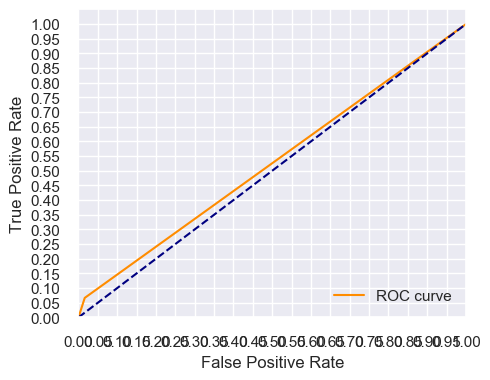

In [34]:
# using best params to fit model
dt_gs_model = DecisionTreeClassifier(criterion='gini',
                             max_depth=None,
                             max_features='sqrt',
                              max_leaf_nodes= None,
                               min_samples_leaf=300,
                               min_samples_split=5
                                
                                    )
dt_gs_model.fit(X_train, y_train)

predictions = dt_gs_model.predict(X_test)
actuals = y_test

# new model report
model_report(dt_gs_model)

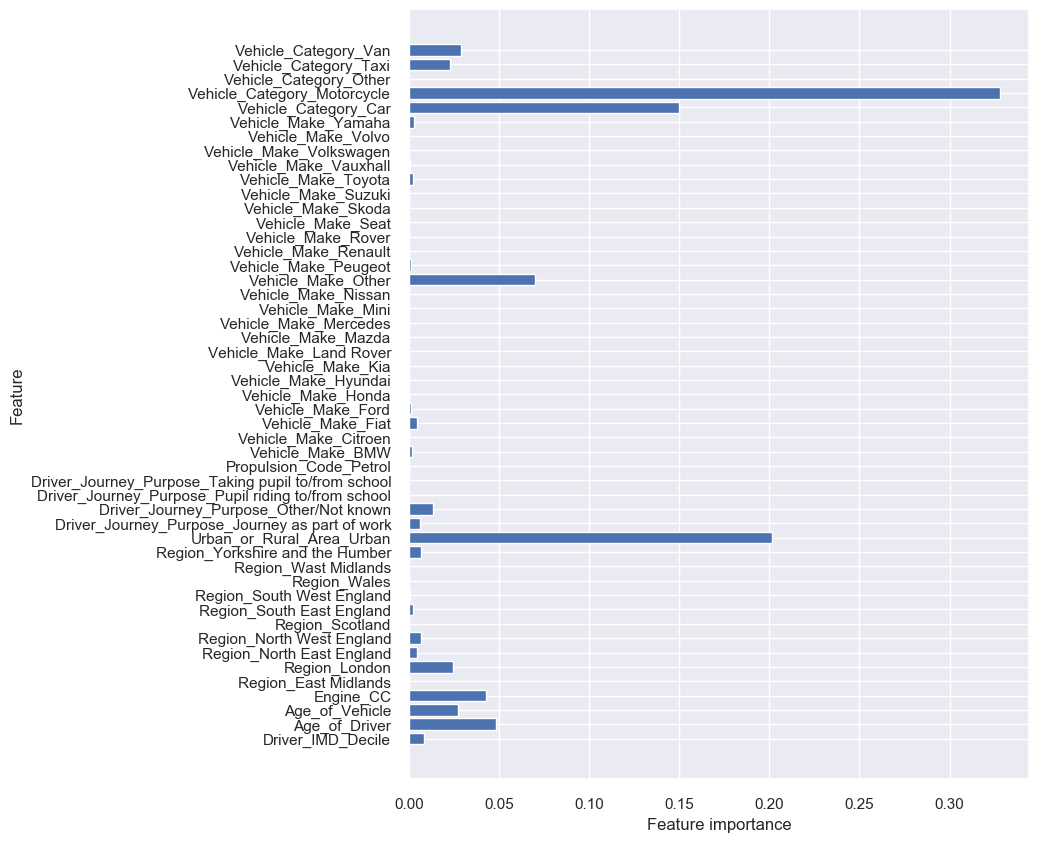

In [35]:
# most important features to tuned model
plot_feats(dt_gs_model)

## random Forest

In [43]:
#initialize and fit random forest
rf_model = Pipeline(steps=[('pca', pca),('rf_model', RandomForestClassifier(random_state=3))])
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)



Cross Validation Scoring:

train score: 99.68%
test score: 73.23%
cross val score: 73.84%
AUC  : 53.84%


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      7562
           1       0.40      0.15      0.22      2512

    accuracy                           0.73     10074
   macro avg       0.58      0.54      0.53     10074
weighted avg       0.68      0.73      0.68     10074


Confusion matrix:


,pred non,pred fatal
actual non,6996,566
actual fatal,2131,381


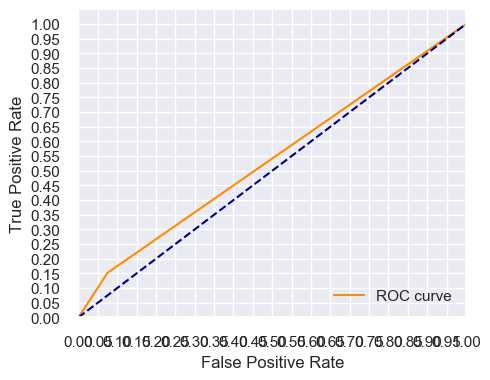

In [44]:
model_report(rf_model)

### random Search

In [40]:
print(rf_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


In [45]:
# set random search params

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 500, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 10, num = 1)]
max_depth.append(None)
min_samples_split = [ 0.01,0.1,3,10,100,300]
min_samples_leaf = [.01,3, 10,50,100,300]
bootstrap = [True, False]
random_grid = {'rf_model__n_estimators': n_estimators,
               'rf_model__max_features': max_features,
               'rf_model__max_depth': max_depth,
               'rf_model__min_samples_split': min_samples_split,
               'rf_model__min_samples_leaf': min_samples_leaf,
               'rf_model__bootstrap': bootstrap}

# fit and search random param combinations
rf_random = RandomizedSearchCV(estimator = rf_model
                               , param_distributions = random_grid
                               , n_iter = 20, cv = 3, verbose=10
                               , random_state=3, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 15.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=40,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('rf_model',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                      

In [46]:
rf_random.best_params_

{'rf_model__n_estimators': 250,
 'rf_model__min_samples_split': 100,
 'rf_model__min_samples_leaf': 10,
 'rf_model__max_features': 'auto',
 'rf_model__max_depth': None,
 'rf_model__bootstrap': True}

###  grid search

In [48]:
# grid search params
param_grid_rf = [
    {'rf_model__criterion': ['entropy','gini'],
    'rf_model__n_estimators': [220,250,270],
    'rf_model__max_depth': [None],
    'rf_model__min_samples_split': [50,100,125],
    'rf_model__min_samples_leaf': [6,8,10,15],
     'rf_model__max_features':['auto'],
     'rf_model__bootstrap':[True]
    }
]

# grid search
gs_rf = GridSearchCV(estimator=rf_model,
                    param_grid=param_grid_rf,
                    scoring='accuracy',
                    cv=3, n_jobs=-1, verbose=10)

# fitting grid search
gs_rf.fit(X_train, y_train)

# best parameters
print('best accuracy: {:.4}%'.format(gs_rf.best_score_ * 100))
print('params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 51.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 65.4min finished


best accuracy: 75.86%
params:
 {'rf_model__bootstrap': True, 'rf_model__criterion': 'entropy', 'rf_model__max_depth': None, 'rf_model__max_features': 'auto', 'rf_model__min_samples_leaf': 8, 'rf_model__min_samples_split': 100, 'rf_model__n_estimators': 250}



Cross Validation Scoring:

train score: 76.46%
test score: 75.86%
cross val score: 76.05%
AUC  : 53.75%


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      7562
           1       0.60      0.10      0.17      2512

    accuracy                           0.76     10074
   macro avg       0.68      0.54      0.51     10074
weighted avg       0.72      0.76      0.69     10074


Confusion matrix:


,pred non,pred fatal
actual non,7400,162
actual fatal,2270,242


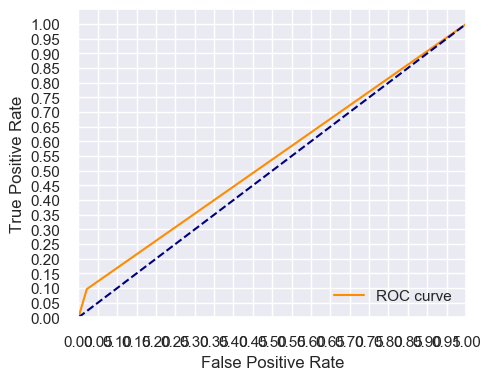

In [49]:
# fitting model using best params
rf_gs_model = RandomForestClassifier(criterion='entropy'
                                 , max_depth=None
                                 , min_samples_leaf=8
                                 , min_samples_split=100
                                 , n_estimators=250
                                 , max_features= 'auto'
                                 , bootstrap= True
                                    )
rf_gs_model.fit(X_train, y_train)

predictions = rf_gs_model.predict(X_test)
actuals = y_test

# new model report
model_report(rf_gs_model)

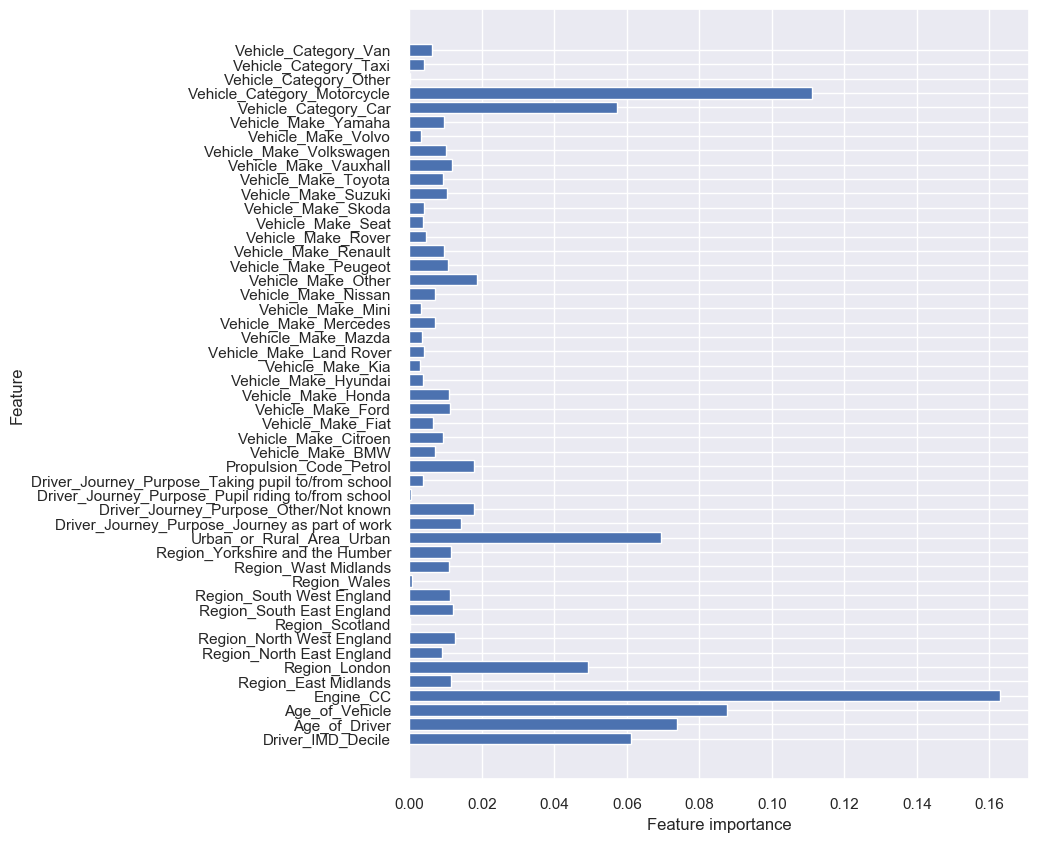

In [50]:
plot_feats(rf_gs_model)

## adaboost

In [51]:
#initialize and fit default model
ada_model = Pipeline(steps=[('pca', pca),('under', RandomUnderSampler()),('ada_model', AdaBoostClassifier(random_state=3))])
ada_model.fit(X_train, y_train)

predictions = ada_model.predict(X_test)


Cross Validation Scoring:

train score: 61.89%
test score: 60.77%
cross val score: 60.74%
AUC  : 57.57%


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.64      0.71      7562
           1       0.32      0.51      0.39      2512

    accuracy                           0.61     10074
   macro avg       0.56      0.58      0.55     10074
weighted avg       0.68      0.61      0.63     10074


Confusion matrix:


,pred non,pred fatal
actual non,4836,2726
actual fatal,1226,1286


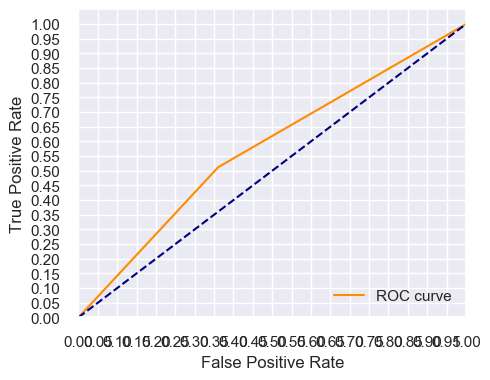

In [52]:
#baseline model report
model_report(ada_model)

In [53]:
print(ada_model)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=40,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('under',
                 RandomUnderSampler(random_state=None, replacement=False,
                                    sampling_strategy='auto')),
                ('ada_model',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=50,
                                    random_state=3))],
         verbose=False)


### random search

In [60]:
#set random search params
learning_rate= [.000001,.00001,.01,.1,1, 1.5]

n_estimators = [50,100, 200, 300]

random_grid = {'ada_model__learning_rate':learning_rate,
               'ada_model__n_estimators': n_estimators
              }

#random grid search
ada_random = RandomizedSearchCV(estimator = ada_model
                               , param_distributions = random_grid
                               , n_iter = 50, cv = 3, verbose=7, scoring='f1'
                               , random_state=3, n_jobs = -1);
# Fit the random search model
ada_random.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  7.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=40,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('under',
                                              RandomUnderSampler(random_state=None,
                                                                 replacement=False,
                                                                 sampling_strategy='auto')),
                                             ('ada_model',
                                              AdaBoostClassifier(

In [61]:
ada_random.best_params_

{'ada_model__n_estimators': 200, 'ada_model__learning_rate': 0.1}

### grid search

In [64]:
#grid search params and fitting grid search
param_grid_ada = [
    {'ada_model__n_estimators': [190,200,230],
    'ada_model__learning_rate': [.08, .1, .15]}
]

# Construct Grid Search
gs_ada = GridSearchCV(estimator=ada_model,
                    param_grid=param_grid_ada,
                    scoring='f1',
                    cv=3, n_jobs=-1, verbose=7)

# Fit using grid search
gs_ada.fit(X_train, y_train)

# Best accuracy and parameters
print('best score: {:.4}%'.format(gs_ada.best_score_ * 100))
print('params:\n', gs_ada.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  9.0min finished


best score: 39.7%
params:
 {'ada_model__learning_rate': 0.1, 'ada_model__n_estimators': 200}



Cross Validation Scoring:

train score: 76.01%
test score: 75.79%
cross val score: 75.97%
AUC  : 53.18%


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.98      0.86      7562
           1       0.61      0.08      0.14      2512

    accuracy                           0.76     10074
   macro avg       0.69      0.53      0.50     10074
weighted avg       0.72      0.76      0.68     10074


Confusion matrix:


,pred non,pred fatal
actual non,7432,130
actual fatal,2309,203


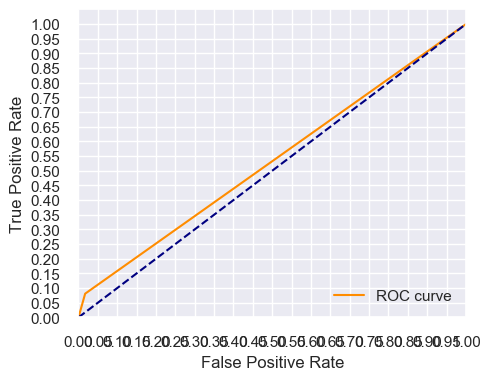

In [65]:
# fit best params
ada_gs_model = AdaBoostClassifier(n_estimators=200,
                                   learning_rate=0.1)
ada_gs_model.fit(X_train, y_train)

predictions = ada_gs_model.predict(X_test)

model_report(ada_gs_model)

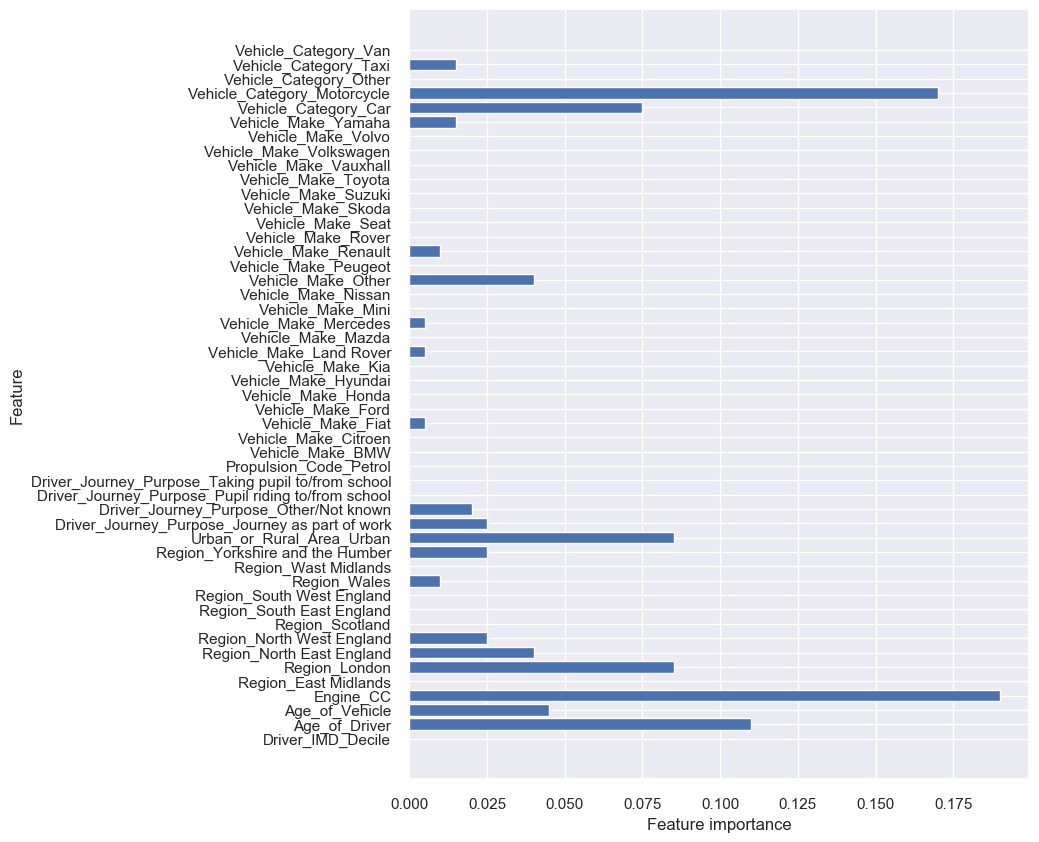

In [66]:
plot_feats(ada_gs_model)

## gradient boost 


Cross Validation Scoring:

train score: 66.0%
test score: 63.18%
cross val score: 62.19%
AUC  : 57.72%


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      7562
           1       0.33      0.47      0.39      2512

    accuracy                           0.63     10074
   macro avg       0.56      0.58      0.56     10074
weighted avg       0.68      0.63      0.65     10074


Confusion matrix:


,pred non,pred fatal
actual non,5189,2373
actual fatal,1336,1176


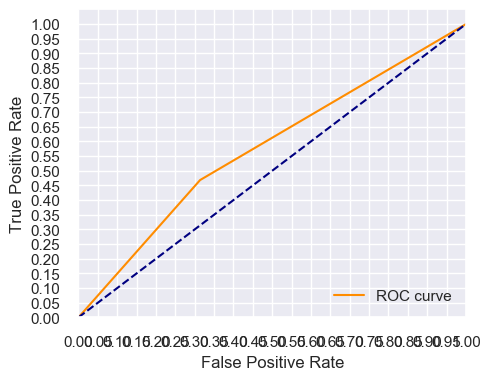

In [67]:
#initialize and fit gradient boost
gbt_model = Pipeline(steps=[('pca', pca),('under', RandomUnderSampler()),('gbt_model', GradientBoostingClassifier(random_state=3))])
gbt_model.fit(X_train, y_train)

predictions = gbt_model.predict(X_test)
actuals = y_test

#baseline model report
model_report(gbt_model)

### random search

In [68]:
print(gbt_model)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=40,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('under',
                 RandomUnderSampler(random_state=None, replacement=False,
                                    sampling_strategy='auto')),
                ('gbt_model',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                  

In [70]:
# setting parameters for random search
learning_rate=[0.09,.1, 0.11]
loss = ['deviance', 'exponential']
max_depth = [None,2,3,4,10,20,50,100]
n_estimators = [50,100,200]
min_samples_split = [2,3,4]
min_samples_leaf = [1,2,3]
# Create the random grid
min_weight_fraction_leaf = [0,0.0001, 0.001]
random_grid = {'gbt_model__learning_rate':learning_rate,
               'gbt_model__loss': loss,
               'gbt_model__max_depth': max_depth,
               'gbt_model__n_estimators': n_estimators,
               'gbt_model__min_samples_split': min_samples_split,
               'gbt_model__min_samples_leaf': min_samples_leaf,
               'gbt_model__min_weight_fraction_leaf': min_weight_fraction_leaf
               
              }

#searching random params
gbt_random = RandomizedSearchCV(estimator = gbt_model
                               , param_distributions = random_grid
                               , n_iter = 20, cv = 3, verbose=5, scoring='f1'
                               , random_state=3, n_jobs = -1)
# fit random search model
gbt_random.fit(X_train, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 39.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=40,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('under',
                                              RandomUnderSampler(random_state=None,
                                                                 replacement=False,
                                                                 sampling_strategy='auto')),
                                             ('gbt_model',
                                              GradientBoostingCla

In [71]:
gbt_random.best_params_

{'gbt_model__n_estimators': 200,
 'gbt_model__min_weight_fraction_leaf': 0.001,
 'gbt_model__min_samples_split': 4,
 'gbt_model__min_samples_leaf': 2,
 'gbt_model__max_depth': 3,
 'gbt_model__loss': 'deviance',
 'gbt_model__learning_rate': 0.11}

### grid search

In [74]:
# grid search params and run search
param_grid_gbt = [
    {'gbt_model__n_estimators': [200,250],
     'gbt_model__min_weight_fraction_leaf':[0.0009, 0.001, 0.002],
    'gbt_model__learning_rate': [0.11,0.15],
    'gbt_model__min_samples_split': [3,4,5],
    'gbt_model__min_samples_leaf': [1,2,3],
    'gbt_model__max_depth': [3]
    }
]

# grid search
gs_gbt = GridSearchCV(estimator=gbt_model,
                    param_grid=param_grid_gbt,
                    scoring='f1',
                    cv=3, n_jobs=-1, verbose=5)

# fit grid search
gs_gbt.fit(X_train, y_train)

# best params
print('best accuracy: {:.4}%'.format(gs_gbt.best_score_ * 100))
print('params:\n', gs_gbt.best_params_)



Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 96.2min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 108.4min finished


best accuracy: 39.4%
params:
 {'gbt_model__learning_rate': 0.15, 'gbt_model__max_depth': 3, 'gbt_model__min_samples_leaf': 1, 'gbt_model__min_samples_split': 3, 'gbt_model__min_weight_fraction_leaf': 0.002, 'gbt_model__n_estimators': 200}


In [ ]:
# fitting best params
gbt_gs_model = GradientBoostingClassifier(learning_rate=0.1,
                                         max_depth=2,
                                         min_samples_leaf=2,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.01,
                                         n_estimators=60)
gbt_gs_model.fit(X_train, y_train)

predictions = gbt_gs_model.predict(X_test)
actuals = y_test

In [ ]:
# new model report
model_report(gbt_gs_model)

Very little improvement was seen between the default and tuned model. In fact, the cross validation didn't show any improvement, and the train accuracy only .01%.  This 

In [ ]:
plot_feats(gbt_gs_model)

## XGBoost

In [ ]:
# initiate model
xgb_model = Pipeline(steps=[('pca', pca),('under', RandomUnderSampler()),('xgb_model', XGBClassifier(random_state=3))])
xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)

model_report(xgb_model)

In [ ]:
print(xgb_model)

### random grid

In [ ]:
#set random search params
learning_rate=[.01, .1, .2, 1]
max_depth = [2,3,6,10, None]
min_child_weight = [0,1,2]
n_estimators = [50,100,200,300]
min_weight_fraction_leaf = [0,0.0001, 0.01, 1]

random_grid = {
               'xgb_model__learning_rate':learning_rate,
               'xgb_model__max_depth': max_depth,
               'xgb_model__min_child_weight':min_child_weight,
               'xgb_model__n_estimators': n_estimators
               
              }

# searching random params
xgb_random = RandomizedSearchCV(estimator = xgb_model
                               , param_distributions = random_grid
                               , n_iter = 20, cv = 3, verbose=1
                               , random_state=3, n_jobs = -1)
# fit random search model
xgb_random.fit(X_train, y_train)

In [ ]:
xgb_random.best_params_

### grid search

In [ ]:
param_grid_xgb = [
    {
         'xgb_model__min_samples_split':[2,3],
         'xbg_model__gamma':[0.01,0.1,.05],
        'xgb_model__min_child_weight': [1,.1,.01],
    'xgb_model__learning_rate': [0.001,0.01],
    'xgb_model__n_estimators': [150,200,250],
    'xgb_model__max_depth': [2,3]}
]

# Construct Grid Search
gs_xgb = GridSearchCV(estimator=pipe_xgb,
                    param_grid=param_grid_xgb,
                    scoring='accuracy',
                    cv=3, n_jobs=-1, verbose=1)

# Fit using grid search
gs_xgb.fit(X, y)

# Best accuracy and parameters
print('best score: {:.3}%'.format(gs_xgb.best_score_ * 100))
print('params:\n', gs_xgb.best_params_)

xgb_gs_model = XGBClassifier(learning_rate=0.001,
                             max_depth=3,
                             min_child_weight=1,
                             n_estimators=150)
xgb_gs_model.fit(X_train, y_train)

predictions = xgb_gs_model.predict(X_test)
actuals = y_test

In [ ]:
model_report(xgb_gs_model)

In [ ]:
plot_feats(xgb_gs_model)

## SVC

SVM uses kernel trick, deals well with colinearity, and is better for categorical data. It may not always be worth the extra time it takes, though.

In [ ]:
svm_model = Pipeline(steps=[('pca', pca),('under', RandomUnderSampler()),('svm_model', svm.SVC(random_state=3))])
svm_model.fit(X_train, y_train)

predictions = svm_model.predict(X_test)

model_report(svm_model)

In [ ]:
print(svm_model)

### random search

In [ ]:
# set random search params

clf_C = [0.001, 0.01,.1,1.]
clf_gamma = [.001,.01,1.]
clf_kernel = ['rbf', 'linear']

random_grid = {
               'svm_model__C': clf_C,
               'svm_model__gamma': clf_gamma,
               'svm_model__kernel': clf_kernel
               }

# fit and search random param combinations
svm_random = RandomizedSearchCV(estimator = svm_model
                               , param_distributions = random_grid
                               , n_iter = 10, cv = 3, verbose=2
                               , random_state=3, n_jobs = -1)
# Fit the random search model
svm_random.fit(X_train, y_train)

In [ ]:
svm_random.best_params_

### grid search

In [ ]:
# Set grid search params
param_grid_svm = [
 
  {'svm_model__C': [.001,0.1, 1], 'svm_model__gamma': [0.1, 0.01, 0.001], 'svm_model__kernel': ['rbf']},
 ]

# Construct grid search
gs_svm = GridSearchCV(estimator=svm_model,
            param_grid=param_grid_svm,
            scoring='recall',
            cv=3, verbose=1, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('Best score: %.3f' % gs_svm.best_score_)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

In [ ]:
svm_gs_model = svm.SVC(C=1
                       ,gamma=0.01
                            ,kernel='rbf'
                             )
svm_gs_model.fit(X_train, y_train)

predictions = svm_gs_model.predict(X_test)

In [ ]:
plot_feats(svm_gs_model)

## conclusion

While I was able to increase the accuracy of the models, the recall rate always went down with fine tuning. It's possible to increase the recall rate if that was the goal, though, and it may be something to come back to in the future. 

Resampling the dataset to have even fatal and non fatal accidents might be a way to improve the models.
